# <center>Dog Vs Cat Classification</center>

### <center> The data used for this work is available on kaggle in the link: https://www.kaggle.com/c/dogs-vs-cats/data </center>

In [18]:
labels = ['cat', 'dog']
BATCH_SIZE = 64
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_DEPTH = 3
EPOCH = 50

## 1. Load data

In [19]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [20]:
import os
import numpy as np
import cv2 as cv
from PIL import Image
from sklearn.model_selection import train_test_split

In [21]:
def get_images(path_image):
    list_images = []
    for label in labels:
        path_image_label = path_image + '/' + label
        fichiers = [f for f in os.listdir(path_image_label) if os.path.isfile(os.path.join(path_image_label, f))]
        for fichier in fichiers:
            try:
                img = cv.imread(path_image_label + '/' + fichier)
                im_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                resized_img = cv.resize(im_rgb, (IMG_WIDTH, IMG_HEIGHT))
                list_images.append([resized_img, labels.index(label)])
            except:
                print(fichier)

    return np.array(list_images)

In [22]:
train_data = get_images('./dogs-vs-cats/train')
test_data = get_images('./dogs-vs-cats/test')

<ipython-input-21-3ef3bc7a7b55>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(list_images)


In [23]:
print('{} images in training set'.format(len(train_data)))
print('{} images in test set'.format(len(test_data)))

20000 images in training set
5000 images in test set



We will divide the training images into 2 parts:

* 80% for the train
* 20% for validation



In [24]:
train_data, validation_data = train_test_split(train_data, test_size=0.20, random_state=42)

In [25]:
print('{} images in training set'.format(len(train_data)))
print('{} images in validation set'.format(len(validation_data)))
print('{} images in test set'.format(len(test_data)))

16000 images in training set
4000 images in validation set
5000 images in test set


In [26]:
print('{} images in training set'.format(len(train_data)))
print('--- {} CATS IMAGES IN TRAINING SET'.format([y for _, y in train_data].count(0)))
print('--- {} DOGS IMAGES IN TRAINING SET'.format([y for _, y in train_data].count(1)))

16000 images in training set
--- 7981 CATS IMAGES IN TRAINING SET
--- 8019 DOGS IMAGES IN TRAINING SET


In [27]:
print('{} images in validation set'.format(len(validation_data)))
print('--- {} CATS IMAGES IN VALIDATION SET'.format([y for _, y in validation_data].count(0)))
print('--- {} DOGS IMAGES IN VALIDATION SET'.format([y for _, y in validation_data].count(1)))

4000 images in validation set
--- 2019 CATS IMAGES IN VALIDATION SET
--- 1981 DOGS IMAGES IN VALIDATION SET


In [28]:
print('{} images in test set'.format(len(test_data)))
print('--- {} CATS IMAGES IN TEST SET'.format([y for _, y in test_data].count(0)))
print('--- {} DOGS IMAGES IN TEST SET'.format([y for _, y in test_data].count(1)))

5000 images in test set
--- 2500 CATS IMAGES IN TEST SET
--- 2500 DOGS IMAGES IN TEST SET


## 2. Data Visualization

In [29]:
import matplotlib.pyplot as plt

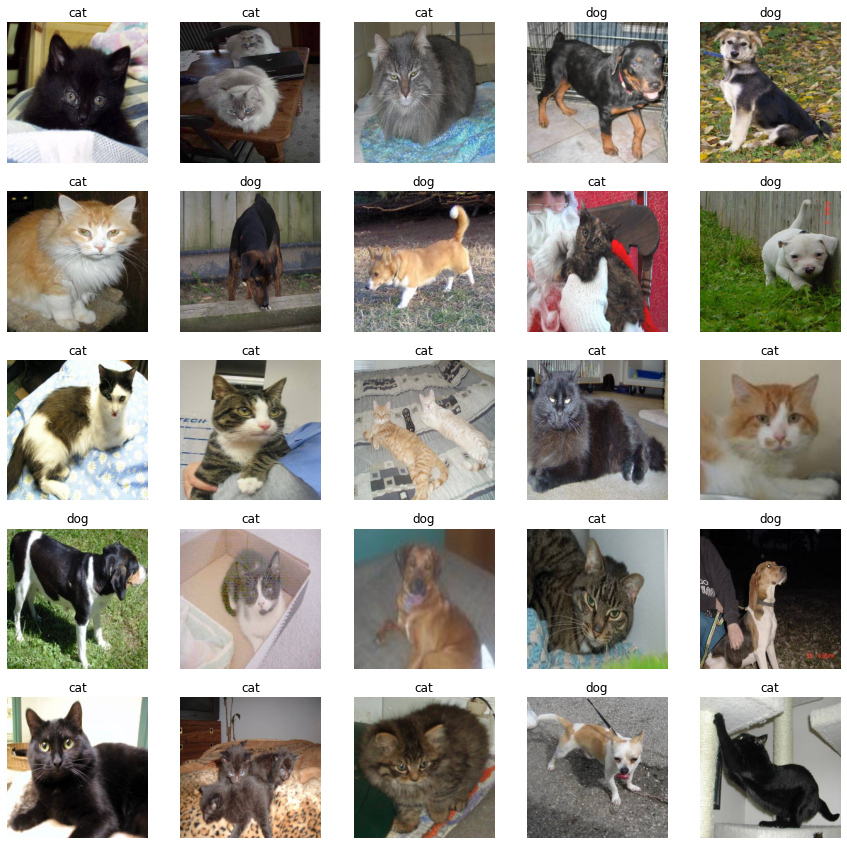

In [30]:
plt.figure(figsize=(15, 15))
for k, i in np.ndenumerate(np.random.randint(train_data.shape[0], size=25)):
    ax = plt.subplot(5, 5, k[0] + 1)
    plt.imshow(train_data[i][0], cmap='gray')
    plt.title(labels[train_data[i][1]])
    plt.axis("off")

## 3. Prepare Data

In [31]:
from tempfile import mkdtemp

In [32]:
def prepare_data(data):
    x = []
    y = []
    for feature, label in data:
        x.append(feature)
        y.append(label)

    x = np.array(x)
    y = np.array(y)
        
    return x, y

In [33]:
x_train_int, y_train = prepare_data(train_data)
x_val_int, y_val = prepare_data(validation_data)
x_test_int, y_test = prepare_data(test_data)

### For reasons of memory availability, we must create 3 memory spaces to arrays stored in a binary file on the disk, corresponding to the training, validation and test data.

In [34]:
filename_train = os.path.join(mkdtemp(), 'newfile_train.dat')
x_train = np.memmap(filename_train, dtype='float32', mode='w+', shape=x_train_int.shape)

filename_val = os.path.join(mkdtemp(), 'newfile_val.dat')
x_val = np.memmap(filename_val, dtype='float32', mode='w+', shape=x_val_int.shape)

filename_test = os.path.join(mkdtemp(), 'newfile_test.dat')
x_test= np.memmap(filename_test, dtype='float32', mode='w+', shape=x_test_int.shape)

In [35]:
x_train[:] = x_train_int[:]
x_val[:] = x_val_int[:]
x_test[:] = x_test_int[:]

### We divide the pixels of each image by 255

In [36]:
for i in range(x_train.shape[0]):
    x_train[i] = x_train[i] / 255

for i in range(x_val.shape[0]):
    x_val[i] = x_val[i] / 255

for i in range(x_test.shape[0]):
    x_test[i] = x_test[i] / 255

In [37]:
print('The new shape of images is {}'.format(x_train[0].shape))
print('Number of images train is {}'.format(x_train.shape[0]))

The new shape of images is (224, 224, 3)
Number of images train is 16000


## 3. Data augmentation

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [39]:
datagen = ImageDataGenerator(
    rotation_range = 20, 
    zoom_range = 0.25, 
    width_shift_range=0.15,  
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip = True,  
    vertical_flip=True,
    fill_mode="nearest")

## 4. Build the model

In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, AveragePooling2D, Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation, Input, Concatenate, Layer, ZeroPadding2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions

In [41]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    # Layer 2
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = Add()([x, x_skip])     
    x = Activation('relu')(x)
    return x

def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)
    # Layer 2
    x = Conv2D(filter, (3,3), padding = 'same')(x)
    x = BatchNormalization(axis=3)(x)
    # Add Residue
    x = Add()([x, x_skip])     
    x = Activation('relu')(x)
    return x

def ResNet34(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = Input(shape)
    x = ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [3, 4, 6, 3]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = AveragePooling2D((2,2), padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    # x = Dense(classes, activation = 'softmax')(x)
    x = Dense(classes, activation = 'sigmoid')(x)
    model = Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

def ResNet18(shape = (32, 32, 3), classes = 10):
    # Step 1 (Setup Input Layer)
    x_input = Input(shape)
    x = ZeroPadding2D((3, 3))(x_input)
    # Step 2 (Initial Conv layer along with maxPool)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    # Define size of sub-blocks and initial filter size
    block_layers = [2, 2, 2, 2]
    filter_size = 64
    # Step 3 Add the Resnet Blocks
    for i in range(4):
        if i == 0:
            # For sub-block 1 Residual/Convolutional block not needed
            for j in range(block_layers[i]):
                x = identity_block(x, filter_size)
        else:
            # One Residual/Convolutional Block followed by Identity blocks
            # The filter size will go on increasing by a factor of 2
            filter_size = filter_size*2
            x = convolutional_block(x, filter_size)
            for j in range(block_layers[i] - 1):
                x = identity_block(x, filter_size)
    # Step 4 End Dense Network
    x = AveragePooling2D((1,1), padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(512, activation = 'relu')(x)
    x = Dense(128, activation = 'relu')(x)
    # x = Dense(classes, activation = 'softmax')(x)
    x = Dense(classes, activation = 'sigmoid')(x)
    model = Model(inputs = x_input, outputs = x, name = "ResNet34")
    return model

In [42]:
model = ResNet18(shape=(224, 224, 3), classes=1)

In [43]:
model.summary()

Model: "ResNet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 115, 115, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 115, 115, 64) 256         conv2d[0][0]                     
___________________________________________________________________________________________

## 5. Compile the model

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

In [45]:
opt = Adam(lr=1e-4, decay=1e-4 / EPOCH)

In [46]:
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=[Precision(), Recall()])

## 6. Train the model

In [47]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

In [48]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), epochs=EPOCH, validation_data=(x_val, y_val),
                    steps_per_epoch=len(x_train) // BATCH_SIZE)

Epoch 1/50
250/250 [==============================] - 128s 512ms/step - loss: 0.7190 - precision: 0.6289 - recall: 0.6009 - val_loss: 0.7185 - val_precision: 0.4388 - val_recall: 0.0308
Epoch 2/50
250/250 [==============================] - 130s 521ms/step - loss: 0.5841 - precision: 0.6994 - recall: 0.6512 - val_loss: 0.6196 - val_precision: 0.7603 - val_recall: 0.5477
Epoch 3/50
250/250 [==============================] - 127s 509ms/step - loss: 0.5435 - precision: 0.7408 - recall: 0.6911 - val_loss: 0.6122 - val_precision: 0.8161 - val_recall: 0.4750
Epoch 4/50
250/250 [==============================] - 127s 509ms/step - loss: 0.5080 - precision: 0.7563 - recall: 0.7294 - val_loss: 0.5929 - val_precision: 0.9081 - val_recall: 0.4190
Epoch 5/50
250/250 [==============================] - 127s 507ms/step - loss: 0.4870 - precision: 0.7772 - recall: 0.7523 - val_loss: 0.4821 - val_precision: 0.7183 - val_recall: 0.8844
Epoch 6/50
250/250 [==============================] - 129s 515ms/step 

Epoch 45/50
250/250 [==============================] - 123s 493ms/step - loss: 0.1189 - precision: 0.9482 - recall: 0.9557 - val_loss: 0.1613 - val_precision: 0.9285 - val_recall: 0.9374
Epoch 46/50
250/250 [==============================] - 122s 490ms/step - loss: 0.1145 - precision: 0.9488 - recall: 0.9592 - val_loss: 0.1693 - val_precision: 0.9173 - val_recall: 0.9631
Epoch 47/50
250/250 [==============================] - 123s 491ms/step - loss: 0.1114 - precision: 0.9543 - recall: 0.9572 - val_loss: 0.1692 - val_precision: 0.9559 - val_recall: 0.9086
Epoch 48/50
250/250 [==============================] - 124s 494ms/step - loss: 0.1177 - precision: 0.9487 - recall: 0.9531 - val_loss: 0.1570 - val_precision: 0.9432 - val_recall: 0.9389
Epoch 49/50
250/250 [==============================] - 122s 488ms/step - loss: 0.1137 - precision: 0.9519 - recall: 0.9566 - val_loss: 0.1603 - val_precision: 0.9722 - val_recall: 0.9001
Epoch 50/50
250/250 [==============================] - 122s 487ms

## 7. Evaluate model

In [49]:
evaluate = model.evaluate(x_test, y_test, verbose=0)
print("Loss of the model is - " , evaluate[0])
print("Precision of the model is - " , evaluate[1]*100 , "%")
print("Recall of the model is - " , evaluate[2]*100 , "%")

Loss of the model is -  0.1656012386083603
Precision of the model is -  95.46218514442444 %
Recall of the model is -  90.88000059127808 %


## 8. Save model

In [50]:
model.save('my_model.h5')
model.save_weights('./weights/my_weights')

## 9. Load model

In [51]:
model_old = tf.keras.models.load_model('my_model.h5')
model_old.load_weights('./weights/my_weights')

In [52]:
evaluate = model_old.evaluate(x_test, y_test, verbose=0)
print("Loss of the model is - " , evaluate[0])
print("Precision of the model is - " , evaluate[1]*100 , "%")
print("Recall of the model is - " , evaluate[2]*100 , "%")

Loss of the model is -  0.1656012386083603
Precision of the model is -  95.46218514442444 %
Recall of the model is -  90.88000059127808 %


## 10. Analysis Model

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

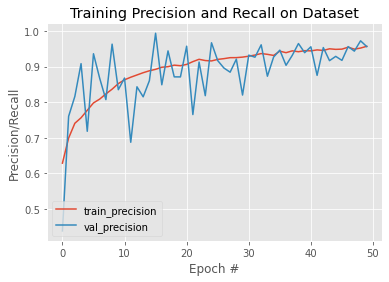

In [54]:
# plot the training loss and accuracy
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['precision'], label="train_precision")
plt.plot(np.arange(0, N), history.history['val_precision'], label="val_precision")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")
plt.savefig("plot.png")

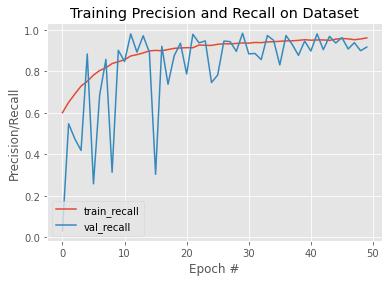

In [55]:
# plot the training loss and accuracy
N = EPOCH
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history['recall'], label="train_recall")
plt.plot(np.arange(0, N), history.history['val_recall'], label="val_recall")
plt.title("Training Precision and Recall on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Precision/Recall")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [56]:
predictions = np.array(tf.greater(model.predict(x_test), .5))
predictions = predictions.reshape(1,-1)[0]
predictions = np.array([0 if i == False else True for i in predictions])
predictions[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [57]:
print(classification_report(y_test, predictions, target_names = ['Cats (Class 0)','Dogs (Class 1)']))

                precision    recall  f1-score   support

Cats (Class 0)       0.91      0.96      0.93      2500
Dogs (Class 1)       0.95      0.91      0.93      2500

      accuracy                           0.93      5000
     macro avg       0.93      0.93      0.93      5000
  weighted avg       0.93      0.93      0.93      5000



In [58]:
cm = confusion_matrix(y_test, predictions)
cm

array([[2392,  108],
       [ 228, 2272]])

In [59]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<AxesSubplot:>

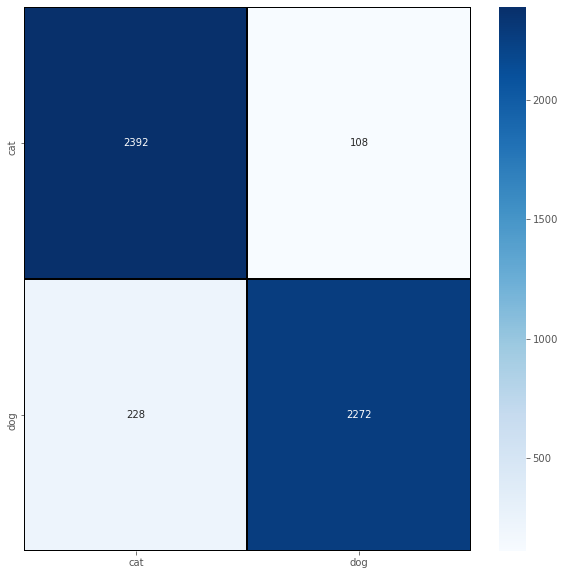

In [60]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)